In [1]:
import matplotlib.pyplot as plt

import os
%matplotlib inline
from matplotlib.colors import LogNorm

import numpy as np
import math

import soundfile as sf
from scipy.signal import spectrogram

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
import soundfile as sf


# Índice

1. [Introdução](#int)

    1.1 [Ondas Harmônicas](#ondas)
    

2. [Emissores de VLF](#emissores)

    2.1 [Amostragem](#amostragem)
    
    
3. [Distâncias e Azimute](#dist)


4. [Explorações](#exp)


# 1. Sinais em VLF

<a id="int"></a>

As placas de som modernas permitem taxas de amostragem de 48kHz, 96kHz ou até mesmo $192kHz$. Pelo Teorema de Amostragem, com estas frequências de amostragem é possível receber sinais até $24kHz$, $48kHz$ e $96kHz$ respetivamente.

Estas frequências abrangem as bandas de rádio que, habitualmente, são designadas de frequências muito baixas (ou [VLF](https://en.wikipedia.org/wiki/Very_low_frequency) - Very Low Frequencies na sigla inglesa) dos $0$ aos $30kHz$, e parte das frequências baixas (ou [LF](https://en.wikipedia.org/wiki/Low_frequency) - Low Frequencies na sigla inglesa) dos $30kHz$ aos $300kHz$. 

Uma vez que o nosso objeto de estudo são as frequências que vão de $0$ até aos $96kHz$, chamaremos, indiscriminadamente, a esta banda de frequências VLF. Ou seja, referir-nos-emos a VLF como todas as frequências que se conseguem receber com um simples placa de som de computador.

Vamos começar o nosso guião analisando uma pequena gravação em VLF:

In [ ]:
Audio("media/vlf_sample.wav") 

In [3]:
input_signal, sample_rate = sf.read("media/vlf_sample.wav")

A gravação foi efetuada com uma taxa de amostragem de:

In [123]:
print('A taxa de amostragem do ficheiro é de %i Hz' %sample_rate)

A taxa de amostragem do ficheiro é de 192000 Hz


Vejamos a sua forma:

(-0.12264765625000001, 2.57560078125, -0.5434646606445312, 0.5826187133789062)

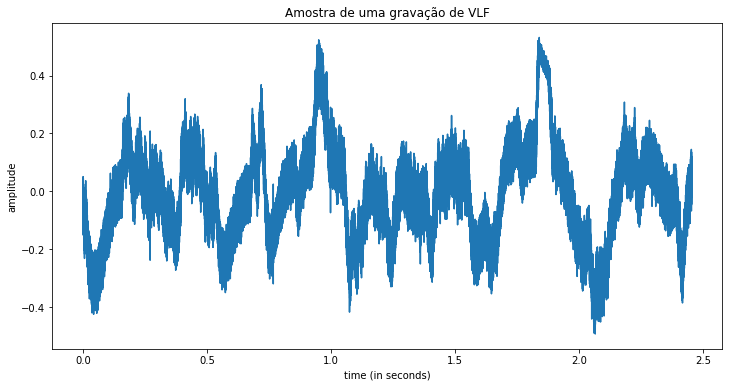

In [76]:
time_array = np.arange(0, len(input_signal)/sample_rate, 1/sample_rate)
setup_graph(title='Amostra de uma gravação de VLF', x_label='time (in seconds)', y_label='amplitude', fig_size=(12,6))
plt.plot(time_array, input_signal)
plt.axis('tight')

Calculando a transformada de Fourier ao sinal anterior, obtemos o seguinte espetro:

(-4800.0, 100800.0, -0.005021550523151496, 0.10545366903736804)

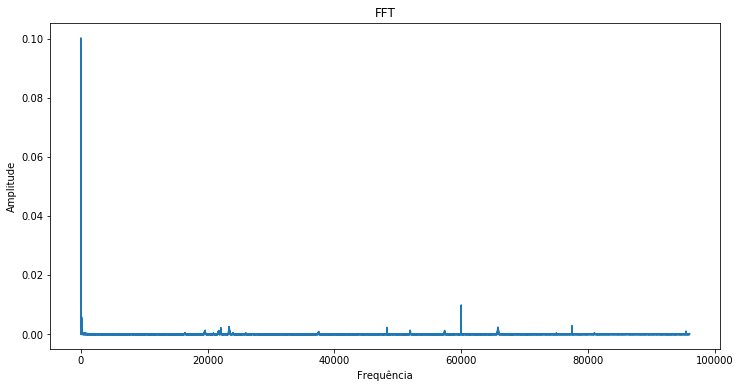

In [77]:
fft_out = np.fft.rfft(input_signal)

fft_mag = np.abs(fft_out)/len(fft_out)

num_samples = len(input_signal)

rfreqs=sample_rate/2*np.linspace(0,1,num_samples/2+1)

setup_graph(title='FFT', x_label='Frequência', y_label='Amplitude', fig_size=(12,6))
plt.plot(rfreqs, fft_mag)
plt.axis('tight')

Como seria de esperar, a frequência máxima capturada pela gravação é de $f_{\max} = \frac{192000}{2} = 96kHz$.

Aparentemente, para além do pico em $f_0 = 0$, que representa a componente continua no sinal, não aparenta haver mais informação relevante.

Isto acontece porque as diferenças de amplitude 

Para conseguirmos visualizar convenientemente as várias componentes do espetro, teremos que o tranaformar de uma escala linear para uma escala logaritmica, aplicando a transformação: $y = 20 \log_{10} (x)$. Ou seja:

In [14]:
eps=1e-12 

O valor $eps=10^{-12}$ é uma constante usada para evitar erros derivados de eventuais $\log_{10}(0)$.

In [67]:
fft_mag_dB = 20*np.log10(fft_mag+eps)

Assim, o novo espetro em escala logaritmica, em decibeis, fica:

(-4800.0, 100800.0, -152.2568113400781, -13.66282523900411)

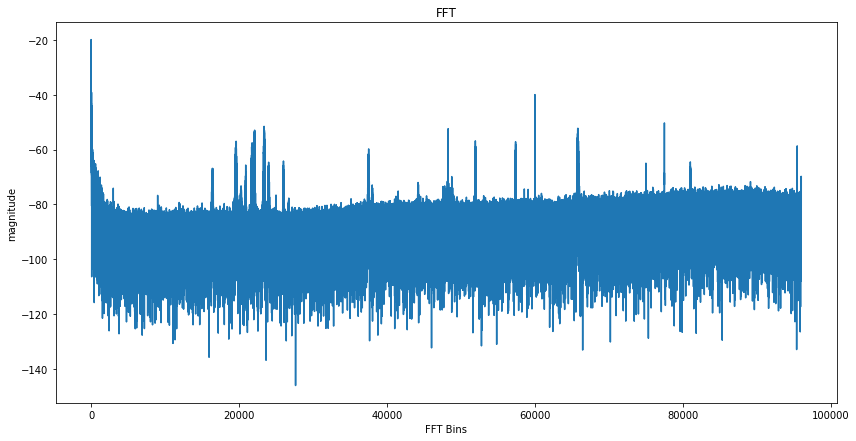

In [68]:
setup_graph(title='FFT', x_label='Frequência', y_label='Potência Espetral (dB)', fig_size=(12,6))
plt.plot(rfreqs, fft_mag_dB)
plt.axis('tight')

No espetro anterior, já começamos a observar alguns picos a emergir da parte central. Pelo facto de ainda estarmos a calcular a transformada de Fourier em todo o sigal, o ruido cria uma banda central larga e ofusca ainda muito informação. 



Ao criarmos um espetrograma obtemos:

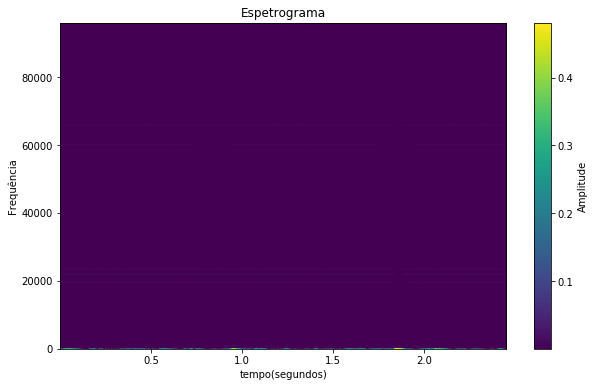

In [91]:
setup_graph(title='Espetrograma', x_label='tempo(segundos)', y_label='Frequência', fig_size=(10,6))

Sxx,f, t, im = plt.specgram(input_signal, Fs=sample_rate, scale_by_freq=False, scale='linear', NFFT=1024, mode='magnitude')
plt.colorbar(im).set_label('Amplitude')

Numa escala linear, as diferenças em amplitude diferem de algumas potências de $10$ e como consequência a frequência $f_0$ satura a imagem e impossiblita a visualização do informação relevante.

Fazendo a mesma representação numa escala logaritmica, `scale='dB'` , obtemos:

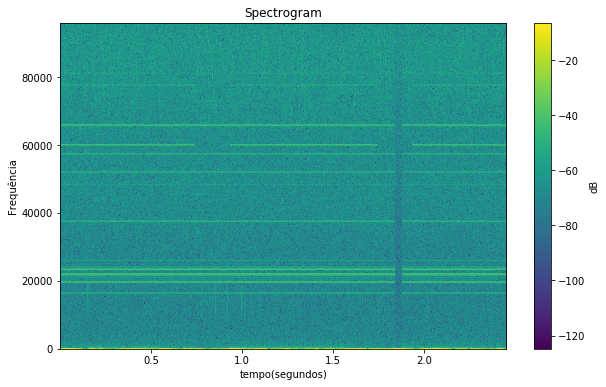

In [113]:
setup_graph(title='Spectrogram', x_label='tempo(segundos)', y_label='Frequência', fig_size=(10,6))

Sxx, freqs, times, im = plt.specgram(input_signal, Fs=sample_rate, scale_by_freq=False, scale='dB', NFFT=1024, mode='magnitude')
plt.colorbar(im).set_label('Potência Espetral (dB)')

Procedendo como anteriormente, obtemos (apesar do gráfico anterior estar em escala logaritmica o seu output está em escala linear):

In [114]:
Sxx_dB = 20*np.log10(Sxx.astype(np.float32)+ eps)

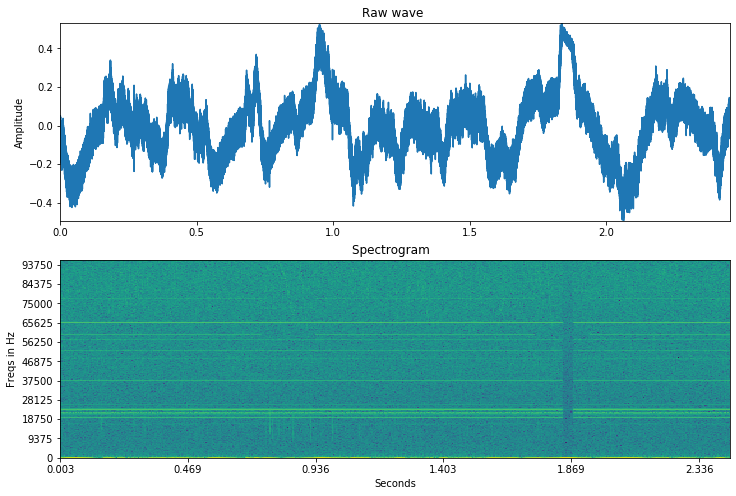

In [115]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave ')
ax1.set_ylabel('Amplitude')

Tempgrav= float(len(input_signal))/float(sample_rate)

ax1.plot(np.arange(0,Tempgrav,1/float(sample_rate)), input_signal)
ax1.autoscale(enable=True, axis='both', tight=True)

ax2 = fig.add_subplot(212)
ax2.imshow(Sxx_dB, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::50])
ax2.set_xticks(times[::100])
ax2.set_title('Spectrogram  ')
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')
ax2.autoscale(enable=True, axis='both', tight=True)
plt.show()


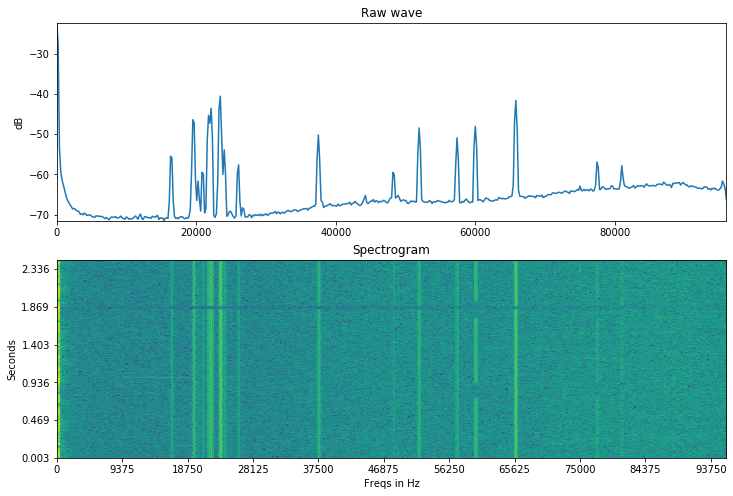

In [116]:
fig = plt.figure(figsize=(12, 8))

ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave')
ax1.set_ylabel('Potência Espetral (dB)')

Tempgrav= float(len(input_signal))/float(sample_rate)

ax1.plot(freqs, Sxx_dB.mean(axis=1))
ax1.autoscale(enable=True, axis='both', tight=True)

ax2 = fig.add_subplot(212)
ax2.imshow(Sxx_dB.T, aspect='auto', origin='lower', 
           extent=[freqs.min(), freqs.max(),times.min(), times.max()])
ax2.set_yticks(times[::100])
ax2.set_xticks(freqs[::50])
ax2.set_title('Spectrogram')
ax2.set_ylabel('Seconds')
ax2.set_xlabel('Freqs in Hz')
ax2.autoscale(enable=True, axis='both', tight=True)
plt.show()

Agora sim! O sinal que aparentava não ter nenhuma informação, afinal apresenta um espetro com uns picos claros em algumas frequências particulares. Como iremos ver já a seguir, cada pico desses é o sinal de um transmissor de VLF...

$\frac{\textrm{Sample Rate *} k}{\textrm{Total N of Sample Points} }\;\;\;\; \textrm{(Hz)}$

# 2. Emissores de VLF

<a id="emissores"></a>

Nas atividades que propomos desenvolver, vamos trabalhar com ondas rádio de frequências muito baixas, inferiores a $96kHz$. Por questões técnicas, esta banda de frequências foi a utilizada pelos pioneiros das telecomunicações, Marconi, Fessenden, entre outros, [5], nas suas primeiras experiências, e consequentemente, usada pelas primeiras estações comerciais e governamentais de rádio nas primeiras décadas do século XX, [6]. Por operarem com frequências da ordem dos kHz, estas primeiras estações de telecomunicações necessitavam de antenas gigantescas, ver Fig. 1, para serem eficazes, tornando-os dispendiosos e de difícil manutenção. 
Com o desenvolvimento da tecnologia, a utilização destas frequências baixas caiu em desuso tendo sido substituídas por sistemas mais práticos que operam a frequências bem mais elevadas.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/Grimeton_VLF_masts.jpg" alt="Drawing"  style="width: 75%;"/>

[fonte](https://upload.wikimedia.org/wikipedia/commons/b/bb/Grimeton_VLF_masts.jpg)

Atualmente, esta banda de VLF é maioritariamente utilizada para emissões militares, uma vez que estas frequências permitem obter uma cobertura global do planeta e têm a capacidade de penetrar na água dos oceanos a profundidades que possibilitam a comunicação com submarinos submergidos.

<img src="https://www.visitcumbria.com/photos/simon/anthorn-7922b.jpg" alt="Drawing" style="width: 50%;"/>

[fonte](https://www.visitcumbria.com/photos/simon/anthorn-7922b.jpg)

A localização geográfica da grande parte destes emissores é conhecida:

| Frequência (Hz) | Nome | Latitude | Longitude |
| --- | --- | --- | --- |
| 16400 | [JXN](https://en.wikipedia.org/wiki/Noviken_VLF_Transmitter) | 66.967° | 13.883° |
| 19600 | [GBZ](https://en.wikipedia.org/wiki/Anthorn_Radio_Station) | 54.900° | -03.267° |
| 20270 | ICV | 40.917° | 09.733° |
| 20900 | FTA | 48.550° | 02.567° |
| 21750 | [HWU](https://en.wikipedia.org/wiki/HWU_transmitter) | 46.717° | 01.250° |
| 22100 | GQD | 54.733° | -02.883° |
| 23400 | [DHO38](https://en.wikipedia.org/wiki/VLF_transmitter_DHO38) | 53.083° | 07.617° |
| 24000 | NAA | 44.650° | -67.283° |
| 25200 | NML | 46.367° | -98.333° |
| 26700 | TBB | 37.417° | 27.317° |
| 37500 | NRK/TFK | 63.850° | -22.467° |
| 40800 | NAU | 18.400° | -67.183° |
| 45900 | NSY | 37.126° | 14.436° |

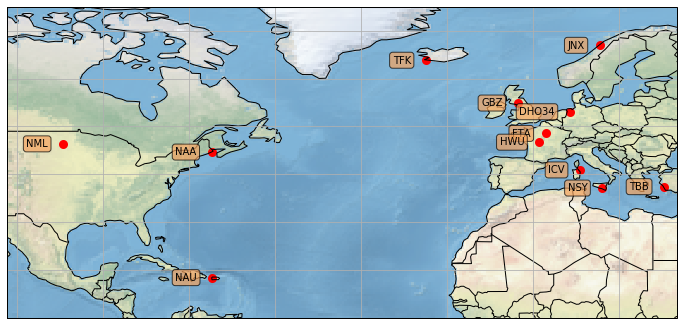

In [122]:
emissores_mapa()

In [ ]:
lons = [13.883333,-3.278,9.733,2.567,1.250,-2.883,7.617,-67.283,-98.333,27.317,-22.467,-67.183,14.436]
lats = [66.966667,54.900,40.917,48.550,46.717,54.900,53.083,44.650,46.367,37.417,63.850,18.400,37.126]
nomes=['JNX','GBZ','ICV','FTA','HWU','GQD','DHO34','NAA','NML','TBB','TFK','NAU','NSY']

# 3. Distâncias e Azimute

<a id="dist"></a>

Assumindo um modelo esférico para a Terra, a distância entre quaisquer dois pontos:$P_1=(lat_1,log_1)$ e $P_2=(lat_2,log_2)$ , é dada por:
\begin{equation}
D= R \arccos(\sin(lat_1)\sin(lat_2)+\cos(lat_1)\cos(lat_2)\cos(long_2-long_1))
\end{equation}
sendo $R=6371km$, o raio médio da Terra.

Ver também o [link](http://www.movable-type.co.uk/scripts/latlong.html).

O Azimute, em radianos, pode ser calculado através de:

$$\theta=\arctan 2(Y,X),
$$

onde 
$$
X=\cos(lat_1)\sin(lat_2)-\sin(lat_1)\cos(lat_2) \cos(lon_2-lon_1)
$$
e
$$
Y= \sin(lon_2-lon_1) \cos(lat_2),
$$

onde consideramos o $P_1$ o ponto onde se localiza o nosso observatório.

Para ser mais simples criamos duas funções:

In [ ]:
def distancia(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    rlat1 = math.radians(lat1)
    rlon1 = math.radians(lon1)
    rlat2 = math.radians(lat2)
    rlon2 = math.radians(lon2)
    
    a = math.sin(rlat1) * math.sin(rlat2) + math.cos(rlat1)*math.cos(rlat2)*math.cos(rlon2-rlon1)
    d = radius * math.acos(a)
    print('A  distância entre os dois pontos é de %fkm' %d)
    return d

In [ ]:
def Azimute(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination

    rlat1 = math.radians(lat1)
    rlon1 = math.radians(lon1)
    rlat2 = math.radians(lat2)
    rlon2 = math.radians(lon2)
    
    X = math.cos(rlat1) * math.sin(rlat2) - math.sin(rlat1)*math.cos(rlat2)*math.cos(rlon2-rlon1)
    Y = math.sin(rlon2-rlon1)*math.cos(rlat2)
    
    az = math.degrees(math.atan2(Y,X))
    az =  (az+360) % 360 
    az = (az+180) % 360 # Azimute final
    
    print('O Azimute final entre os dois pontos é de %f°' %az)

    return az

In [ ]:
Viseu = (40.6582338,-7.9123233)
DHO34 = (53.083, 7.617)

In [ ]:
distancia(DHO34, Viseu)

In [ ]:
Azimute(DHO34, Viseu)

In [ ]:
mapa_2pontos(DHO34, Viseu, nomes=['DHO34','Viseu'])

In [ ]:
make_spect_plot('../Observações/data_files/logfile3_02_02_2011.WAV')

## 4. Explorações

<a id="exp"></a>

<img src='logfile1_02_02_2011OVERLAP.png'>

In [ ]:
(sample_rate, input_signal) = read("data/Avelinha-5-5-2017-I.wav")
f, t, Sxx = spectrogram(np.sum(input_signal, axis=1),
                        sample_rate, nperseg=512, nfft=4096)


Links:
1. [ Sudden Ionospheric Disturbances Monitoring Station A118](https://sidstation.loudet.org/)

2. [vlf.it](http://www.vlf.it/)

3. [Construção de recetores rádio como introdução à Física das Telecomunicações - parte I ](https://www.spf.pt/magazines/GFIS/113/913)

4. [Construção de recetores rádio como introdução à Física das Telecomunicações - parte II ](https://www.spf.pt/magazines/GFIS/114/931)

5. [Ouvindo o emissor SAQ de Grimeton ](https://www.spf.pt/magazines/GFIS/118/969)


https://fairyonice.github.io/implement-the-spectrogram-from-scratch-in-python.html
    
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.specgram.html
    
https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.psd.html 

https://www.kaggle.com/davids1992/speech-representation-and-data-exploration